This is my Second project

🧠 Project Goal
To perform customer segmentation using RFM analysis and clustering (e.g., K-Means) to understand consumer behavior based on:

How recently they made a purchase (Recency)
How often they make purchases (Frequency)
How much money they spend (Monetary)

# 1. Preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

url = "https://drive.google.com/uc?id=1a23FkkFUuRLeFDXmYoYpjo5_5FAAYDom"

df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


# 2. Data Cleansing

In [24]:
# Drop cancelled transactions (Invoices containing the letter 'C')
df = df[~df['Invoice'].astype(str).str.contains('C', na=False)]

# Drop transactions with missing values
df.dropna(inplace=True)

# Filter only transactions from the United Kingdom (can be changed as needed)
df = df[df['Country'] == 'United Kingdom']

# Convert the 'InvoiceDate' column to datetime data type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Add the TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

# Check the results
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


# 3. Calculate RFM (Recency, Frequency, Monetary)

In [25]:
# Set the reference date (e.g., 1 day after the last transaction)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Create the RFM table
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalPrice': 'sum'                                      # Monetary
}).reset_index()

# Rename the columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Display the summary statistics
rfm.describe()

,CustomerID,Recency,Frequency,Monetary
count,5353.000000,5353.000000,5353.000000,5353.000000
mean,15556.524566,203.138240,6.266766,2750.447883
std,1581.187812,210.106131,11.998015,12077.255964
min,12346.000000,1.000000,1.000000,0.000000
25%,14190.000000,26.000000,1.000000,335.520000
50%,15564.000000,99.000000,3.000000,848.710000
75%,16922.000000,382.000000,7.000000,2212.280000
max,18287.000000,739.000000,337.000000,608821.650000


# 4. RFM Scoring, Segmentation & Scaling

In [26]:
# Scoring with quartiles
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method="first"), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine scores
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,326,12,77556.46,2,4,4,244
1,12608.0,405,1,415.79,1,1,2,112
2,12745.0,487,2,723.85,1,2,2,122
3,12746.0,541,1,254.55,1,1,1,111
4,12747.0,2,26,9276.54,4,4,4,444


In [27]:
# Take only the RFM columns for clustering
rfm_for_cluster = rfm[['Recency', 'Frequency', 'Monetary']]

# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_cluster)

# 5. KMeans Clustering

## Silhouette score

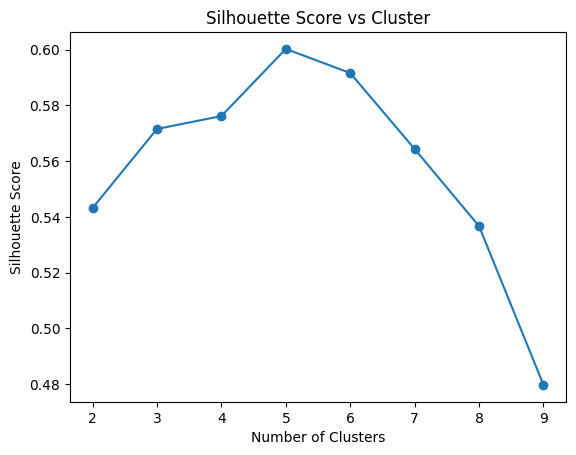

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Determine the optimal number of clusters with Silhouette Score (or elbow method)
sil = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    sil.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Plot Silhouette Score
plt.plot(k_range, sil, marker='o')
plt.title('Silhouette Score vs Cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## Elbow Method - yellowbrick

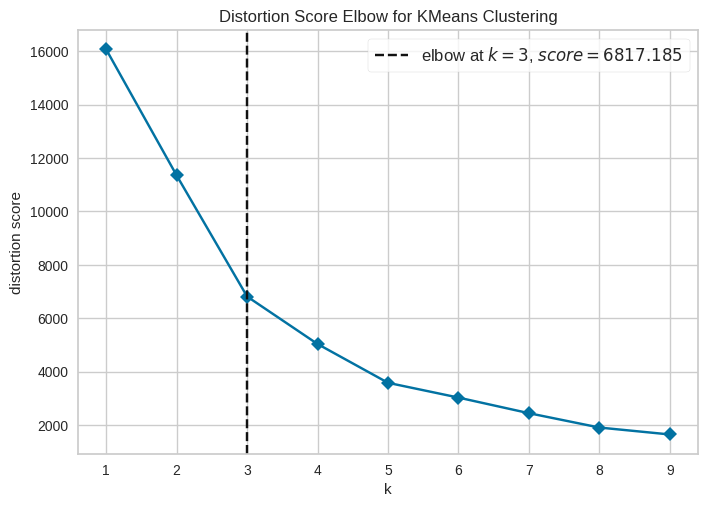

In [32]:
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Create KMeans
model = KMeans(random_state=42, n_init=10)

# Create visualizer
visualizer = KElbowVisualizer(model, k=(1,10), metric='distortion', timings=False)

# Fit and plot
visualizer.fit(rfm_scaled)
visualizer.show()
plt.show()

## From the silhouette results, we obtained a K of 5, and the elbow results with Yellowbrick gave us a K of 3.

We will use the number 4 as a midpoint, noting that:

The silhouette score is still high (almost 0.59).
Inertia has also begun to decline sharply.
It provides more diverse segmentation.

# 6. Final Clustering + Visualization + Analysis

In [33]:
# Fit final model
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

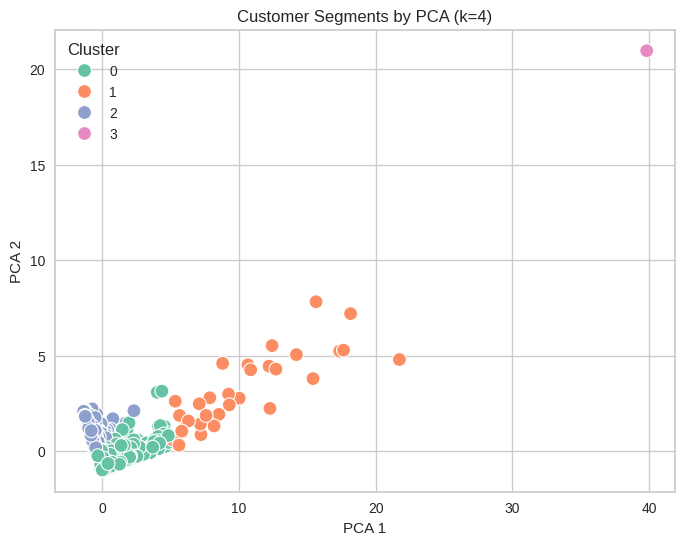

In [34]:
from sklearn.decomposition import PCA

# PCA reduction into 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)

# embedded to the DF
rfm['PCA1'] = pca_components[:, 0]
rfm['PCA2'] = pca_components[:, 1]

# Plotting
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segments by PCA (k=4)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


In [35]:
# summary analysis per cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_summary

,Recency,Frequency,Monetary
Cluster,,,
0,67.09,7.42,2885.00
1,26.26,104.65,82286.87
2,463.24,2.19,699.40
3,1.00,145.00,608821.65


📍 Cluster 0
* Recency: 67 days → it's been a while since their last purchase.
* Frequency: 7.42 → shops occasionally, not frequently.
* Monetary: 2.8 million → spends a fair amount.

📝 Interpretation:
➡️ Average customers, not very active but their contribution is decent. Could be a target for loyalty programs to encourage more frequent purchases.

---

📍 Cluster 1
* Recency: 26 days → still quite active.
* Frequency: 104.65 → shops very frequently.
* Monetary: 82 million → very high contribution.

📝 Interpretation:
➡️ Loyal and high-value customers. This is the gold segment

Highly recommended to maintain their loyalty with exclusive rewards, VIP promotions, etc.

---

📍 Cluster 2
* Recency: 463 days (!) → hasn't shopped in a very long time.
* Frequency: 2.19 → rarely shops.
* Monetary: 699 thousand → small purchases.

📝 Interpretation:
➡️ Almost lost customers. Might have switched to competitors.

Could try to win them back with a "we miss you" promotion or a return discount.

---

📍 Cluster 3
* Recency: 1 day (!) → just made a purchase very recently.
* Frequency: 145 → shops most frequently.
* Monetary: 608 million

📝 Interpretation:
➡️ This is the king of all customers, VVIP class.

Must be very well taken care of. Offer exclusive benefits, early access, etc.
That's why they were so far out in the PCA plot: their behavior is extremely different from the others.